In [17]:
import os
import csv
import numpy as np
import utils
import hrr_utils
import time
import random

from scipy import spatial
from scipy.spatial import distance
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
%matplotlib inline

cwd = os.getcwd()


alph = 'abcdefghijklmnopqrstuvwxyz#.'
N=1000
D = len(alph)
dic1 = letter_vecs = 2 * (np.random.randn(D, N) < 0) - 1
dic2 = letter_vecs = 2 * (np.random.randn(D, N) < 0) - 1


def read_verbs(url):
    keys = ['low', 'medium', 'high']
    verbs = {key: [] for key in keys}
    
    with open(url, 'rb') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        curr_verbs = []
        i = 0
        for row in reader:
            if row[0] in keys:
                curr_verbs = verbs[row[0]]
            else:
                curr_verbs.append([row[0], row[1]])
            i+=1
    return verbs

def ngram_encode(ngram_str, letter_vecs):
    vec = np.zeros(letter_vecs.shape[1])
    
    full_str = '#' + ngram_str + '.'
    
    
    for il, l in enumerate(full_str[:-2]):
        trivec = letter_vecs[alph.find(full_str[il]), :]
        for c3 in range(1, 3):
            trivec = trivec * np.roll(letter_vecs[alph.find(full_str[il+c3]), :], c3)
            
        vec += trivec
    return vec

def ngram_encode_cl(ngram_str, letter_vecs):
    vec = ngram_encode(ngram_str, letter_vecs)
    
    return 2* (vec + 0.1*(np.random.rand(letter_vecs.shape[1])-0.5) > 0) - 1

def genX(verbs):
    X = np.zeros((len(verbs), N)) # Exclusively difference PAST1-PRES1
    PRES1 = np.zeros((len(verbs), N))
    PRES2 = np.zeros((len(verbs), N))
    PAST1 = np.zeros((len(verbs), N))
    PAST2 = np.zeros((len(verbs), N))
    
    for m in range(len(verbs)):
        pair = verbs[m]
        PRES1[m] = ngram_encode_cl(pair[1], dic1)
        PRES2[m] = ngram_encode_cl(pair[1], dic2)
        PAST1[m] = ngram_encode_cl(pair[0], dic1)
        PAST2[m] = ngram_encode_cl(pair[0], dic2)
#         print(pair[0], np.sum(PRES1[m]), pair[1], np.sum(PRES2[m]))
        
    #X = np.where(PAST1-PRES1 > 0, 1, -1)
    X = PAST1-PRES1
    return X, PRES1, PRES2, PAST1, PAST2

def gen_verb_set(verbs, freq_sizes):
    keys = ['high', 'medium', 'low']
    verb_set_keys = ['dif', 'pres1', 'pres2', 'past1', 'past2']
    size = sum([freq_sizes[freq] for freq in keys])    
    verb_set = {key: np.zeros((size, N)) for key in verb_set_keys}
    i = 0
    verbs_to_encode = []
    for freq in keys:
        size = freq_sizes[freq]
        indices = list(np.random.choice(len(verbs[freq]), size, replace=False))
        verbs_to_encode += [verbs[freq][index] for index in indices]
        
    verb_set['dif'], verb_set['pres1'], verb_set['pres2'], verb_set['past1'], verb_set['past2'] = genX(verbs_to_encode)

    return verb_set       
        
def train(tv, past, present):
    tv += np.multiply(past, present)
    return tv

def reg_train(tv, past, present, sim):
    pred = np.multiply(tv, present)
    #pred = np.where(pred>0, 1, -1)
    #print (sim(pred, past)),
    tv += ((N-sim(pred, past))/float(N)) * np.multiply(past, present)
    return tv

def train_diff(tv, past2, present1, present2):
    tv += np.multiply(present1, past2-present2)
    return tv

def reg_train_diff(tv, past2, present1, present2):
    pred = np.multiply(tv, present1) + present2
    #pred = np.where(pred>0, 1, -1)
    #print (sim(pred, past)),
    tv += ((N-sim(pred, past2))/float(N)) * np.multiply(past2-present2, present1)
    return tv

def outer_train(W, past, present):
    # col x row
    W += np.outer(present, past)
    return W

def outer_reg_train(W, Past, Present, sim):
    pred = np.dot(W, Present)
    W += ((N*N-sim(pred, Past))/float(N*N)) * np.outer(Past, Present)
    return W

def outer_train_diff(W, past2, present1, present2):
    W += np.outer(present1, past2-present2)
    return W

def outer_reg_train_diff(W, past2, present1, present2, sim):
    #W.T.dot(trainpres1[:k].T).T + trainpres2[:k]*N
    pred = np.dot(W, present1) + present2*N
    W += ((N*N-sim(pred, past2))/float(N*N)) * np.outer(present1, past2-present2)
    return W

def closed_train(Past, Present):
    return np.dot(np.linalg.pinv(Present), Past)

def cap_closed_train(Past, Present):
    return np.dot(np.linalg.pinv(Present,rcond=5e-2), Past)

def sim(x, y, dist=None):
    if len(x.shape) == 1 or len(y.shape)==1:
        return np.dot(x, y)
    return np.sum(np.multiply(x, y), axis=1)

def compare(pred, past2):
    acc = 0
    indices = []
    for i in range(pred.shape[0]):
        sims = sim(past2, pred[i])
        predi = np.argmax(sims)
        acc += i == predi
        indices.append((i, predi))
    return acc/float(past2.shape[0]), indices
        
def round_to_tick(number):
    """Round a number to the closest half integer."""
    return round(number * 2) / 2

def graph_onetype(x, y, ystd, accuracy, title=None, xlabel='number of words', ylabel='average dot product', legend='upper left'):   
    plt.figure(1)
    plt.subplot(211)

    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.tick_params(axis='both', which='minor', labelsize=12)

    start = round_to_tick(min(y) - max(ystd))
    end = round_to_tick(max(y) + max(ystd))
    
    ystd = np.clip(ystd, max(-8, start-.5), min(8, end+.5))
    plt.plot(x, y, c='b', lw=2, label='Train')
    plt.fill_between(x, y-ystd, y+ystd, facecolor='b', alpha=0.1)
    plt.legend(loc=legend,fontsize=12)

    plt.xlabel('Number Training Examples',fontsize=16)
    plt.ylabel('Feature Similarity',fontsize=16)
#     plt.title(title,fontsize=16)
    plt.tight_layout()
    
    plt.subplot(212)
    plt.plot(x, accuracy)
    plt.xlabel('Number Training Examples',fontsize=16)
    plt.ylabel('Accuracy',fontsize=16)


def graph(x, y1, y2, y1std, y2std, accuracy, irreg_accuracy, title=None, xlabel='number of words', ylabel='average dot product', legend='upper left'):   
    plt.figure(1)
    plt.subplot(211)
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.tick_params(axis='both', which='minor', labelsize=12)
    
    start = round_to_tick(min(min(y1), min(y2)) - max(max(y1std),max(y2std)))
    end = round_to_tick(max(max(y1), max(y2)) + max(max(y1std),max(y2std)))
    
    y1std = np.clip(y1std, max(-8, start-.5), min(8, end+.5))
    y2std = np.clip(y2std, max(-8, start-.5), min(8, end+.5))
    

    plt.plot(x, y1, c='b', lw=2, label='Regular')
    plt.plot(x, y2, c='g', lw=2, label='Irregular')

    plt.fill_between(x, y1-y1std, y1+y1std, facecolor='b', alpha=0.1)
    plt.fill_between(x, y2-y2std, y2+y2std, facecolor='g', alpha=0.1)
    
#     plt.fill_between(x, y2-y2std, y2+y2std, color='none', alpha=0.3, hatch="////", edgecolor="g")


    plt.legend(loc=legend,fontsize=12)

    plt.xlabel('Number Training Examples',fontsize=16)
    plt.ylabel('Feature Similarity',fontsize=16)
#     plt.title(title,fontsize=16)

    plt.tight_layout()

    plt.subplot(212)
    plt.plot(x, accuracy, c='b', label='Regular')
    plt.plot(x, irreg_accuracy, c='g', label='Irregular')
    plt.xlabel('Number Training Examples',fontsize=16)
    plt.ylabel('Accuracy',fontsize=16)
    plt.legend(loc=legend,fontsize=12)

In [2]:
irreg_verbs1 = read_verbs('data/cleaned/R&M_irregular.csv')
irreg_verbs2 = read_verbs('data/cleaned/Brown_irregular_std=1.csv')
reg_verbs = read_verbs('data/cleaned/Brown_regular_std=0.25.csv')


In [3]:

irreg_verbs = irreg_verbs1

for freq, tenses in irreg_verbs2.items():
    irreg_verbs[freq] += tenses
    
for k, v in irreg_verbs.items():
    print (k, len(v))
    
comb_verbs = reg_verbs
for freq, tenses in irreg_verbs.items():
    comb_verbs[freq] += tenses

('high', 8)
('medium', 217)
('low', 49)


In [4]:
for k, v in irreg_verbs.items():
    print (k, len(v))
    
for k, v in reg_verbs.items():
    print (k, len(v))

('high', 8)
('medium', 217)
('low', 49)
('high', 260)
('medium', 1590)
('low', 871)


In [5]:
"""
10 high freq
410 med freq
86 low freq

irregular
8 high freq
76 med freq
14 low freq

regular
2 high freq
334 med freq
72 low freq 
"""
irreg_freqs = {'high': 8, 'medium': 76, 'low': 14}
reg_freqs = {'high': 2, 'medium': 334, 'low': 72}
comb_freqs = {'high': 10, 'medium': 410, 'low': 86}
irreg_vecs = gen_verb_set(irreg_verbs, irreg_freqs)
reg_vecs = gen_verb_set(reg_verbs, reg_freqs)
comb_vecs = gen_verb_set(comb_verbs, comb_freqs)

In [6]:
"""
accuracy % = similarity normalized = similarity / N
-or by thresholding?

1. Try with only irregular: high, medium, low freq
2. Try with only regular: high, medium, low freq
3. Try with both: high, medium, low freq with 2 lines: total and irregular accuracy.
"""

'\naccuracy % = similarity normalized = similarity / N\n-or by thresholding?\n\n1. Try with only irregular: high, medium, low freq\n2. Try with only regular: high, medium, low freq\n3. Try with both: high, medium, low freq with 2 lines: total and irregular accuracy.\n'

In [7]:
def trigram_dict_onetype(past2, pres1, train_func, acc_thresh=N/2, dist=None):
    psi = np.zeros(N)
    psi = train_func(psi, past2[0], pres1[0])
    x = np.arange(1, pres1.shape[0]+1, 1)
    y = np.zeros(pres1.shape[0])
    ystd = np.zeros(pres1.shape[0])
    accuracy = np.zeros(pres1.shape[0])
    for k in range(1,past2.shape[0]):
        pred = np.multiply(psi, pres1[:k])/float(N)
        sim1 = sim(pred, past2[:k], dist)
        
        y[k] = sim1.mean()
        ystd[k] = np.nanstd(sim1, axis=0)
        accuracy[k], indices = compare(pred, past2[:k])
#         if k%10 == 0:
#             print sim1.shape
#             print indices
 
        psi = train_func(psi, past2[k], pres1[k])
    return x,y,ystd,accuracy

In [8]:
x,y,ystd,accuracy = trigram_dict_onetype(irreg_vecs['past2'], irreg_vecs['past1'], train)

figures/unregularized_trigam_dict-N=1000-W=98-171129


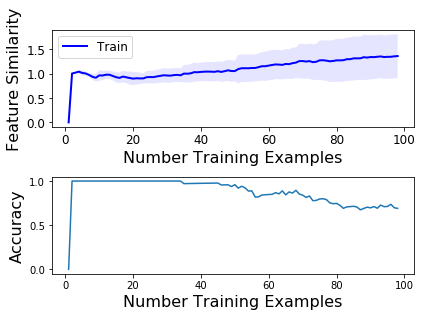

In [9]:
title = 'unregularized'
legend = 'upper left'
graph_onetype(x,y,ystd,accuracy,title=title,legend=legend)
fname =  ('figures/'+title+'_trigam_dict-N=' + str(N) + '-W=' + str(y.shape[0]) 
          + '-' + time.strftime('%y%m%d'))
print fname


figures/unregularized_trigam_dict-N=1000-W=408-171129


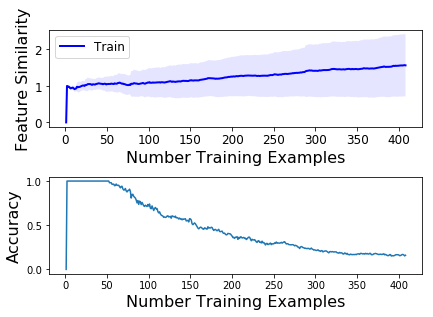

In [10]:
x,y,ystd,accuracy = trigram_dict_onetype(reg_vecs['past2'], reg_vecs['past1'], train)
title = 'unregularized'
legend = 'upper left'
graph_onetype(x,y,ystd,accuracy,title=title,legend=legend)
fname =  ('figures/'+title+'_trigam_dict-N=' + str(N) + '-W=' + str(y.shape[0]) 
          + '-' + time.strftime('%y%m%d'))
print fname

plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)

figures/unregularized_trigam_dict-N=1000-W=408-171129


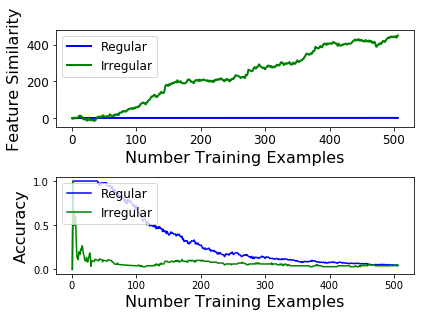

In [11]:
def trigram_dict(comb_past2, comb_pres1, irreg_past2, irreg_pres1, train_func):
    psi = np.zeros(N)
    psi = train_func(psi, comb_past2[0], comb_pres1[0])
    random_vecs = np.random.randn(comb_past2.shape[0], N)
    x = np.arange(1, comb_pres1.shape[0]+1, 1)
    y1 = np.zeros(comb_pres1.shape[0])
    y2 = np.zeros(comb_pres1.shape[0])
    y1std = np.zeros(comb_pres1.shape[0])
    y2std = np.zeros(comb_pres1.shape[0])

    accuracy = np.zeros(comb_pres1.shape[0])
    irreg_accuracy = np.zeros(comb_pres1.shape[0])
    
    for k in range(1,comb_pres1.shape[0]):
        pred = np.multiply(psi, comb_pres1[:k])/float(N)
        irreg_pred = np.multiply(psi, irreg_pres1)
        sim1 = sim(pred, comb_past2[:k])
        sim2 = sim(irreg_pred, irreg_past2)
        
        y1[k] = sim1.mean()
        y1std[k] = np.nanstd(sim1, axis=0)
        y2[k] = sim2.mean()
        y2std[k] = sim2.std(axis=0)
        accuracy[k], indices = compare(pred, comb_past2[:k])
        irreg_accuracy[k], irreg_indices = compare(irreg_pred, irreg_past2[:k])

        psi = train_func(psi, comb_past2[k], comb_pres1[k])
    return x,y1,y2,y1std,y2std, accuracy, irreg_accuracy
# so include combo, irreg
x,y1,y2,y1std,y2std,accuracy, irreg_accuracy = trigram_dict(comb_vecs['past2'], comb_vecs['pres1'], irreg_vecs['past2'], irreg_vecs['pres1'], train)
title = 'unregularized'
legend = 'upper left'
graph(x,y1,y2,y1std,y2std,accuracy,irreg_accuracy, title=title,legend=legend)
fname =  ('figures/'+title+'_trigam_dict-N=' + str(N) + '-W=' + str(y.shape[0]) 
          + '-' + time.strftime('%y%m%d'))
print fname

plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)

In [12]:
def diff_trigram_dict_onetype(past2, pres1, pres2, train_func=train_diff):
    psi = np.zeros(N)
    psi = train_func(psi, past2[0], pres1[0], pres2[0])
    
    x = np.arange(1, pres1.shape[0]+1, 1)
    y = np.zeros(pres1.shape[0])
    ystd = np.zeros(pres1.shape[0])
    accuracy = np.zeros(pres1.shape[0])
    for k in range(1,past2.shape[0]):
        pred = np.multiply(psi, pres1[:k])/float(N) + pres2[:k]
        sim1 = sim(pred, past2[:k])
        
        y[k] = sim1.mean()
        ystd[k] = np.nanstd(sim1, axis=0)
        accuracy[k], indices = compare(pred, past2[:k])

        psi = train_func(psi, past2[k], pres1[k], pres2[k])
    return x,y,ystd,accuracy



figures/unregularized_trigam_dict-N=1000-W=98-171129


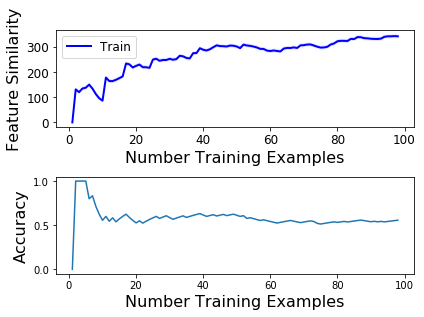

In [13]:
x,y,ystd,accuracy = diff_trigram_dict_onetype(irreg_vecs['past2'], irreg_vecs['past1'], irreg_vecs['pres2'])
title = 'unregularized'
legend = 'upper left'
graph_onetype(x,y,ystd,accuracy,title=title,legend=legend)
fname =  ('figures/'+title+'_trigam_dict-N=' + str(N) + '-W=' + str(y.shape[0]) 
          + '-' + time.strftime('%y%m%d'))
print fname

plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)

figures/unregularized_trigam_dict-N=1000-W=408-171129


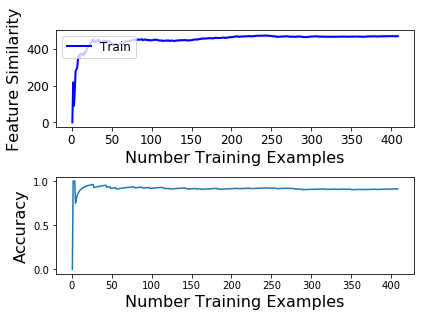

In [14]:
x,y,ystd,accuracy = diff_trigram_dict_onetype(reg_vecs['past2'], reg_vecs['past1'], reg_vecs['pres2'])
title = 'unregularized'
legend = 'upper left'
graph_onetype(x,y,ystd,accuracy,title=title,legend=legend)
fname =  ('figures/'+title+'_trigam_dict-N=' + str(N) + '-W=' + str(y.shape[0]) 
          + '-' + time.strftime('%y%m%d'))
print fname

plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)

figures/unregularized_trigam_dict-N=1000-W=408-171129


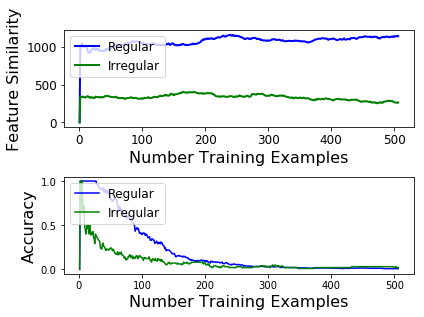

In [15]:
def diff_trigram_dict(comb_past2, comb_pres1, comb_pres2, irreg_past2, irreg_pres1, irreg_pres2, train_func=train_diff):
    psi = np.zeros(N)
    psi = train_func(psi, comb_past2[0], comb_pres1[0], comb_pres2[0])

    x = np.arange(1, comb_pres1.shape[0]+1, 1)
    y1 = np.zeros(comb_pres1.shape[0])
    y2 = np.zeros(comb_pres1.shape[0])
    y1std = np.zeros(comb_pres1.shape[0])
    y2std = np.zeros(comb_pres1.shape[0])

    accuracy = np.zeros(comb_pres1.shape[0])
    irreg_accuracy = np.zeros(comb_pres1.shape[0])

    for k in range(1,comb_past2.shape[0]):
        pred = np.multiply(psi, comb_pres1[:k]) + comb_pres2[:k]
        irreg_pred = np.multiply(psi, irreg_pres1) + irreg_pres2

        sim1 = sim(pred, comb_past2[:k])
        sim2 = sim(irreg_pred, irreg_past2)

        y1[k] = sim1.mean()
        y2[k] = sim2.mean()
        y1std[k] = np.nanstd(sim1, axis=0)
        y2std[k] = np.nanstd(sim2, axis=0)
        accuracy[k], indices = compare(pred, comb_past2[:k])
        irreg_accuracy[k], irreg_indices = compare(irreg_pred, irreg_past2[:k])

        psi = train_func(psi, comb_past2[k], comb_pres1[k], comb_pres2[k])
    return x,y1,y2,y1std,y2std, accuracy, irreg_accuracy

x,y1,y2,y1std,y2std,accuracy, irreg_accuracy = diff_trigram_dict(comb_vecs['past2'], 
                                                                 comb_vecs['pres1'],
                                                                 comb_vecs['pres2'],
                                                                 irreg_vecs['past2'],
                                                                 irreg_vecs['pres1'],
                                                                 irreg_vecs['pres2'])
title = 'unregularized'
legend = 'upper left'
graph(x,y1,y2,y1std,y2std,accuracy,irreg_accuracy, title=title,legend=legend)
fname =  ('figures/'+title+'_trigam_dict-N=' + str(N) + '-W=' + str(y.shape[0]) 
          + '-' + time.strftime('%y%m%d'))
print fname

plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)

figures/regularized_trigam_dict-N=1000-W=408-171129


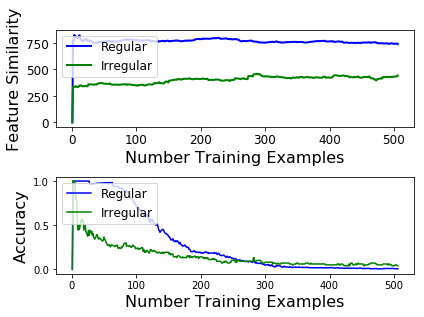

In [18]:
# regularization
x,y1,y2,y1std,y2std,accuracy, irreg_accuracy = diff_trigram_dict(comb_vecs['past2'], 
                                                                 comb_vecs['pres1'],
                                                                 comb_vecs['pres2'],
                                                                 irreg_vecs['past2'],
                                                                 irreg_vecs['pres1'],
                                                                 irreg_vecs['pres2'],
                                                                 reg_train_diff
                                                                )
title = 'regularized'
legend = 'upper left'
graph(x,y1,y2,y1std,y2std,accuracy,irreg_accuracy, title=title,legend=legend)
fname =  ('figures/'+title+'_trigam_dict-N=' + str(N) + '-W=' + str(y.shape[0]) 
          + '-' + time.strftime('%y%m%d'))
print fname

plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)